In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2019-12-19 20:56:19.869286
thunder  Thu Dec 19 20:56:20 2019
[0] GeForce GTX 1080 Ti | 45'C,   0 % | 10895 / 11178 MB | patra(10885M)
[1] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 26'C,   0 % | 10895 / 11178 MB | anthoula(10885M)
[3] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |   213 / 11178 MB | srikanth(203M)
[5] GeForce GTX 1080 Ti | 27'C,   0 % | 10799 / 11178 MB | gerritsn(10789M)
[6] GeForce GTX 1080 Ti | 30'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 28'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Thu Dec 19 20:56:32 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 33%   46C    P2    98W / 250W |  10895MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   25C    P8     7W / 250W |     10Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)
# K.set_session(sess)

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# Setting class weight for retraining:

# compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight = [0.5, 2] # experiment with different values
n_NG , n_G , class_weight

(99455, 2379, [0.5, 2])

## Define Model and Metrics

In [14]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:84]:
        layer.trainable = False
    for layer in mobile_conv.layers[84:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [16]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, rescale=1./255)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [17]:
which_model = mobilenet_model
# which_model = vgg_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,051,649
Non-trainable params: 2,178,240
_________________________________________________________________


In [18]:
# With L2 weight regularizer
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [19]:
start = time.time()
up_history = model.fit_generator(up_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200
50/50 [==============================] - 25s 501ms/step - loss: 0.7017 - Accuracy: 0.5850 - Precision: 0.5784 - Recall: 0.6186 - F1: 0.5853 - AUC: 0.6200 - val_loss: 1.1177 - val_Accuracy: 0.4094 - val_Precision: 0.0469 - val_Recall: 0.4333 - val_F1: 0.0832 - val_AUC: 0.4740
Epoch 2/200
50/50 [==============================] - 23s 457ms/step - loss: 0.6680 - Accuracy: 0.6062 - Precision: 0.6114 - Recall: 0.6335 - F1: 0.6142 - AUC: 0.6589 - val_loss: 0.7069 - val_Accuracy: 0.6812 - val_Precision: 0.0154 - val_Recall: 0.1000 - val_F1: 0.0267 - val_AUC: 0.5882
Epoch 3/200
50/50 [==============================] - 24s 478ms/step - loss: 0.6479 - Accuracy: 0.6288 - Precision: 0.6381 - Recall: 0.6388 - F1: 0.6319 - AUC: 0.6842 - val_loss: 0.3803 - val_Accuracy: 0.8687 - val_Precision: 0.0600 - val_Recall: 0.3000 - val_F1: 0.0968 - val_AUC: 0.7357
Epoch 4/200
50/50 [==============================] - 24s 475ms/step - loss: 0.6492 - Accuracy: 0.6363 - Precision: 0.6394 - Recall: 0.67

Epoch 29/200
50/50 [==============================] - 24s 480ms/step - loss: 0.5866 - Accuracy: 0.6938 - Precision: 0.6779 - Recall: 0.7177 - F1: 0.6905 - AUC: 0.7569 - val_loss: 0.5870 - val_Accuracy: 0.6250 - val_Precision: 0.0245 - val_Recall: 0.1000 - val_F1: 0.0393 - val_AUC: 0.5509
Epoch 30/200
50/50 [==============================] - 23s 466ms/step - loss: 0.5907 - Accuracy: 0.6881 - Precision: 0.7043 - Recall: 0.6990 - F1: 0.6956 - AUC: 0.7521 - val_loss: 0.5902 - val_Accuracy: 0.6156 - val_Precision: 0.0232 - val_Recall: 0.2333 - val_F1: 0.0410 - val_AUC: 0.4653
Epoch 31/200
50/50 [==============================] - 24s 473ms/step - loss: 0.5768 - Accuracy: 0.7006 - Precision: 0.6937 - Recall: 0.7357 - F1: 0.7077 - AUC: 0.7636 - val_loss: 0.5679 - val_Accuracy: 0.6219 - val_Precision: 0.0143 - val_Recall: 0.0667 - val_F1: 0.0235 - val_AUC: 0.4931
Epoch 32/200
50/50 [==============================] - 23s 450ms/step - loss: 0.5726 - Accuracy: 0.7038 - Precision: 0.6989 - Recall: 

50/50 [==============================] - 23s 470ms/step - loss: 0.5845 - Accuracy: 0.6875 - Precision: 0.6964 - Recall: 0.7032 - F1: 0.6920 - AUC: 0.7550 - val_loss: 0.5048 - val_Accuracy: 0.7250 - val_Precision: 0.0493 - val_Recall: 0.3000 - val_F1: 0.0832 - val_AUC: 0.7166
Epoch 58/200
50/50 [==============================] - 23s 458ms/step - loss: 0.5787 - Accuracy: 0.6969 - Precision: 0.6836 - Recall: 0.7185 - F1: 0.6946 - AUC: 0.7647 - val_loss: 0.6296 - val_Accuracy: 0.6750 - val_Precision: 0.0100 - val_Recall: 0.0500 - val_F1: 0.0167 - val_AUC: 0.6956
Epoch 59/200
50/50 [==============================] - 23s 454ms/step - loss: 0.5762 - Accuracy: 0.6875 - Precision: 0.6811 - Recall: 0.7032 - F1: 0.6862 - AUC: 0.7655 - val_loss: 0.5614 - val_Accuracy: 0.6562 - val_Precision: 0.0533 - val_Recall: 0.3000 - val_F1: 0.0879 - val_AUC: 0.5822
Epoch 60/200
50/50 [==============================] - 23s 468ms/step - loss: 0.5867 - Accuracy: 0.6913 - Precision: 0.6831 - Recall: 0.7093 - F1: 

50/50 [==============================] - 23s 455ms/step - loss: 0.5752 - Accuracy: 0.7069 - Precision: 0.6908 - Recall: 0.7212 - F1: 0.6965 - AUC: 0.7695 - val_loss: 0.4692 - val_Accuracy: 0.7188 - val_Precision: 0.0619 - val_Recall: 0.3500 - val_F1: 0.1034 - val_AUC: 0.6505
Epoch 86/200
50/50 [==============================] - 24s 478ms/step - loss: 0.5836 - Accuracy: 0.6938 - Precision: 0.6842 - Recall: 0.7150 - F1: 0.6910 - AUC: 0.7593 - val_loss: 0.6342 - val_Accuracy: 0.6531 - val_Precision: 0.0178 - val_Recall: 0.2000 - val_F1: 0.0325 - val_AUC: 0.4947
Epoch 87/200
50/50 [==============================] - 23s 455ms/step - loss: 0.5889 - Accuracy: 0.6812 - Precision: 0.6920 - Recall: 0.6973 - F1: 0.6886 - AUC: 0.7515 - val_loss: 0.5627 - val_Accuracy: 0.7063 - val_Precision: 0.0350 - val_Recall: 0.1833 - val_F1: 0.0543 - val_AUC: 0.5735
Epoch 88/200
50/50 [==============================] - 24s 479ms/step - loss: 0.5886 - Accuracy: 0.6869 - Precision: 0.7008 - Recall: 0.7059 - F1: 

50/50 [==============================] - 23s 453ms/step - loss: 0.5606 - Accuracy: 0.7025 - Precision: 0.6735 - Recall: 0.7381 - F1: 0.6965 - AUC: 0.7848 - val_loss: 0.6952 - val_Accuracy: 0.6250 - val_Precision: 0.0183 - val_Recall: 0.1500 - val_F1: 0.0321 - val_AUC: 0.5002
Epoch 114/200
50/50 [==============================] - 24s 474ms/step - loss: 0.5864 - Accuracy: 0.6900 - Precision: 0.6846 - Recall: 0.7162 - F1: 0.6912 - AUC: 0.7525 - val_loss: 0.5770 - val_Accuracy: 0.6469 - val_Precision: 0.0337 - val_Recall: 0.4000 - val_F1: 0.0621 - val_AUC: 0.8979
Epoch 115/200
50/50 [==============================] - 23s 454ms/step - loss: 0.5897 - Accuracy: 0.6881 - Precision: 0.6663 - Recall: 0.7089 - F1: 0.6817 - AUC: 0.7500 - val_loss: 0.5926 - val_Accuracy: 0.6656 - val_Precision: 0.0460 - val_Recall: 0.3500 - val_F1: 0.0799 - val_AUC: 0.6176
Epoch 116/200
50/50 [==============================] - 23s 461ms/step - loss: 0.5629 - Accuracy: 0.7169 - Precision: 0.6918 - Recall: 0.7523 - F

50/50 [==============================] - 21s 428ms/step - loss: 0.5829 - Accuracy: 0.6925 - Precision: 0.6753 - Recall: 0.7231 - F1: 0.6925 - AUC: 0.7616 - val_loss: 0.5613 - val_Accuracy: 0.6719 - val_Precision: 0.0627 - val_Recall: 0.5500 - val_F1: 0.1114 - val_AUC: 0.7156
Epoch 142/200
50/50 [==============================] - 23s 456ms/step - loss: 0.5545 - Accuracy: 0.7138 - Precision: 0.7001 - Recall: 0.7333 - F1: 0.7088 - AUC: 0.7904 - val_loss: 0.5494 - val_Accuracy: 0.6875 - val_Precision: 0.0463 - val_Recall: 0.3500 - val_F1: 0.0815 - val_AUC: 0.7349
Epoch 143/200
50/50 [==============================] - 23s 465ms/step - loss: 0.5565 - Accuracy: 0.7150 - Precision: 0.7129 - Recall: 0.7387 - F1: 0.7184 - AUC: 0.7880 - val_loss: 0.6481 - val_Accuracy: 0.6625 - val_Precision: 0.0465 - val_Recall: 0.3667 - val_F1: 0.0795 - val_AUC: 0.7766
Epoch 144/200
50/50 [==============================] - 24s 484ms/step - loss: 0.5711 - Accuracy: 0.7013 - Precision: 0.6960 - Recall: 0.7420 - F

50/50 [==============================] - 23s 452ms/step - loss: 0.5621 - Accuracy: 0.7081 - Precision: 0.7122 - Recall: 0.7304 - F1: 0.7154 - AUC: 0.7789 - val_loss: 0.5609 - val_Accuracy: 0.6750 - val_Precision: 0.0515 - val_Recall: 0.5500 - val_F1: 0.0939 - val_AUC: 0.6973
Epoch 170/200
50/50 [==============================] - 24s 476ms/step - loss: 0.5844 - Accuracy: 0.6806 - Precision: 0.6774 - Recall: 0.7135 - F1: 0.6879 - AUC: 0.7552 - val_loss: 0.6941 - val_Accuracy: 0.6969 - val_Precision: 0.0500 - val_Recall: 0.2500 - val_F1: 0.0804 - val_AUC: 0.6445
Epoch 171/200
50/50 [==============================] - 22s 448ms/step - loss: 0.5675 - Accuracy: 0.7113 - Precision: 0.6979 - Recall: 0.7325 - F1: 0.7099 - AUC: 0.7783 - val_loss: 0.5705 - val_Accuracy: 0.6781 - val_Precision: 0.0202 - val_Recall: 0.2000 - val_F1: 0.0367 - val_AUC: 0.4870
Epoch 172/200
50/50 [==============================] - 23s 454ms/step - loss: 0.5740 - Accuracy: 0.7081 - Precision: 0.6767 - Recall: 0.7498 - F

50/50 [==============================] - 23s 469ms/step - loss: 0.5811 - Accuracy: 0.6900 - Precision: 0.6778 - Recall: 0.7032 - F1: 0.6860 - AUC: 0.7603 - val_loss: 0.7269 - val_Accuracy: 0.6250 - val_Precision: 0.0383 - val_Recall: 0.2167 - val_F1: 0.0628 - val_AUC: 0.5577
Epoch 198/200
50/50 [==============================] - 22s 448ms/step - loss: 0.5725 - Accuracy: 0.6862 - Precision: 0.6715 - Recall: 0.6959 - F1: 0.6762 - AUC: 0.7699 - val_loss: 0.5340 - val_Accuracy: 0.6313 - val_Precision: 0.0182 - val_Recall: 0.0500 - val_F1: 0.0267 - val_AUC: 0.5993
Epoch 199/200
50/50 [==============================] - 23s 458ms/step - loss: 0.5612 - Accuracy: 0.7050 - Precision: 0.7058 - Recall: 0.7251 - F1: 0.7095 - AUC: 0.7815 - val_loss: 0.5405 - val_Accuracy: 0.6531 - val_Precision: 0.0551 - val_Recall: 0.4000 - val_F1: 0.0933 - val_AUC: 0.6443
Epoch 200/200
50/50 [==============================] - 23s 470ms/step - loss: 0.5727 - Accuracy: 0.7175 - Precision: 0.7282 - Recall: 0.7432 - F

In [20]:
print("Time taken:",end-start)

Time taken: 4591.6035804748535


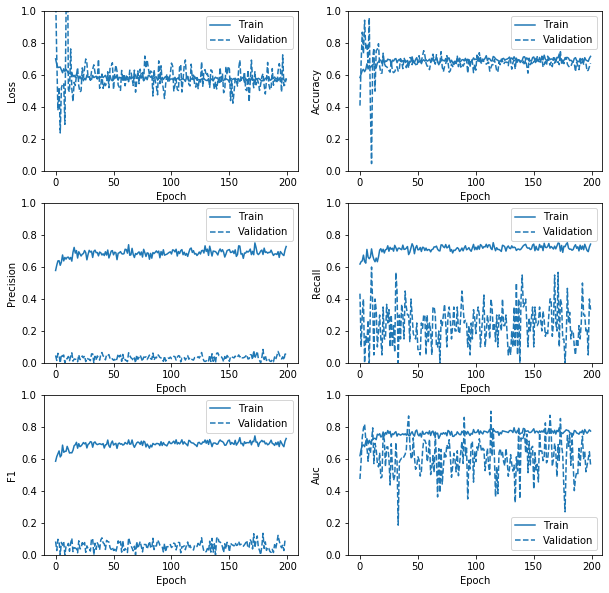

In [21]:
plt.figure(figsize=(10,10))
plot_metrics(up_history)

### Train with UP2 (1:10)

In [22]:
start = time.time()
up2_history = model.fit_generator(up2_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/200
50/50 [==============================] - 21s 426ms/step - loss: 0.6991 - Accuracy: 0.5794 - Precision: 0.1574 - Recall: 0.7100 - F1: 0.2489 - AUC: 0.7540 - val_loss: 0.5459 - val_Accuracy: 0.6906 - val_Precision: 0.0305 - val_Recall: 0.2500 - val_F1: 0.0534 - val_AUC: 0.7422
Epoch 2/200
50/50 [==============================] - 21s 421ms/step - loss: 0.6504 - Accuracy: 0.6275 - Precision: 0.1933 - Recall: 0.8279 - F1: 0.3020 - AUC: 0.7861 - val_loss: 0.6711 - val_Accuracy: 0.6531 - val_Precision: 0.0500 - val_Recall: 0.5250 - val_F1: 0.0896 - val_AUC: 0.6467
Epoch 3/200
50/50 [==============================] - 19s 375ms/step - loss: 0.6315 - Accuracy: 0.6481 - Precision: 0.1888 - Recall: 0.7487 - F1: 0.2884 - AUC: 0.7720 - val_loss: 0.5832 - val_Accuracy: 0.6562 - val_Precision: 0.0067 - val_Recall: 0.1000 - val_F1: 0.0125 - val_AUC: 0.5168
Epoch 4/200
50/50 [==============================] - 20s 396ms/step - loss: 0.6105 - Accuracy: 0.6625 - Precision: 0.1741 - Recall: 0.76

50/50 [==============================] - 22s 432ms/step - loss: 0.3670 - Accuracy: 0.8800 - Precision: 0.2830 - Recall: 0.3007 - F1: 0.2597 - AUC: 0.7905 - val_loss: 0.5192 - val_Accuracy: 0.8406 - val_Precision: 0.0167 - val_Recall: 0.1000 - val_F1: 0.0286 - val_AUC: 0.3059
Epoch 30/200
50/50 [==============================] - 20s 391ms/step - loss: 0.3548 - Accuracy: 0.8888 - Precision: 0.3507 - Recall: 0.3229 - F1: 0.2971 - AUC: 0.7878 - val_loss: 0.4150 - val_Accuracy: 0.8656 - val_Precision: 0.0625 - val_Recall: 0.3000 - val_F1: 0.1008 - val_AUC: 0.6651
Epoch 31/200
50/50 [==============================] - 20s 400ms/step - loss: 0.3609 - Accuracy: 0.8794 - Precision: 0.3167 - Recall: 0.2452 - F1: 0.2511 - AUC: 0.7704 - val_loss: 0.4816 - val_Accuracy: 0.8531 - val_Precision: 0.0375 - val_Recall: 0.1500 - val_F1: 0.0556 - val_AUC: 0.6364
Epoch 32/200
50/50 [==============================] - 22s 431ms/step - loss: 0.3598 - Accuracy: 0.8919 - Precision: 0.4673 - Recall: 0.3649 - F1: 

50/50 [==============================] - 20s 407ms/step - loss: 0.2963 - Accuracy: 0.9094 - Precision: 0.1500 - Recall: 0.0683 - F1: 0.0893 - AUC: 0.7585 - val_loss: 0.2456 - val_Accuracy: 0.9219 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5867
Epoch 58/200
50/50 [==============================] - 20s 409ms/step - loss: 0.2988 - Accuracy: 0.9056 - Precision: 0.1700 - Recall: 0.0615 - F1: 0.0862 - AUC: 0.7513 - val_loss: 0.3331 - val_Accuracy: 0.9187 - val_Precision: 0.0500 - val_Recall: 0.0500 - val_F1: 0.0500 - val_AUC: 0.6637
Epoch 59/200
50/50 [==============================] - 21s 414ms/step - loss: 0.2950 - Accuracy: 0.9131 - Precision: 0.1800 - Recall: 0.0713 - F1: 0.0980 - AUC: 0.7443 - val_loss: 0.3092 - val_Accuracy: 0.9438 - val_Precision: 0.0700 - val_Recall: 0.2000 - val_F1: 0.1000 - val_AUC: 0.9027
Epoch 60/200
50/50 [==============================] - 20s 402ms/step - loss: 0.2879 - Accuracy: 0.9112 - Precision: 0.2400 - Recall: 0

50/50 [==============================] - 21s 428ms/step - loss: 0.2733 - Accuracy: 0.9075 - Precision: 0.0600 - Recall: 0.0157 - F1: 0.0247 - AUC: 0.7855 - val_loss: 0.2983 - val_Accuracy: 0.9625 - val_Precision: 0.1000 - val_Recall: 0.0500 - val_F1: 0.0667 - val_AUC: 0.6684
Epoch 85/200
50/50 [==============================] - 21s 428ms/step - loss: 0.2863 - Accuracy: 0.9019 - Precision: 0.1200 - Recall: 0.0430 - F1: 0.0570 - AUC: 0.7608 - val_loss: 0.2460 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4613
Epoch 86/200
50/50 [==============================] - 20s 409ms/step - loss: 0.2775 - Accuracy: 0.9031 - Precision: 0.1200 - Recall: 0.0667 - F1: 0.0790 - AUC: 0.7866 - val_loss: 0.2737 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6799
Epoch 87/200
50/50 [==============================] - 21s 416ms/step - loss: 0.2764 - Accuracy: 0.9069 - Precision: 0.1000

50/50 [==============================] - 21s 421ms/step - loss: 0.2540 - Accuracy: 0.9200 - Precision: 0.0800 - Recall: 0.0300 - F1: 0.0433 - AUC: 0.7532 - val_loss: 0.1826 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7235
Epoch 112/200
50/50 [==============================] - 20s 408ms/step - loss: 0.2639 - Accuracy: 0.9106 - Precision: 0.0200 - Recall: 0.0067 - F1: 0.0100 - AUC: 0.7697 - val_loss: 0.2455 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4894
Epoch 113/200
50/50 [==============================] - 21s 412ms/step - loss: 0.2497 - Accuracy: 0.9194 - Precision: 0.0600 - Recall: 0.0157 - F1: 0.0247 - AUC: 0.7837 - val_loss: 0.1900 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6670
Epoch 114/200
50/50 [==============================] - 21s 415ms/step - loss: 0.2680 - Accuracy: 0.9081 - Pr

50/50 [==============================] - 21s 419ms/step - loss: 0.2516 - Accuracy: 0.9175 - Precision: 0.0800 - Recall: 0.0250 - F1: 0.0380 - AUC: 0.7702 - val_loss: 0.1941 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6924
Epoch 139/200
50/50 [==============================] - 21s 416ms/step - loss: 0.2723 - Accuracy: 0.9087 - Precision: 0.0400 - Recall: 0.0117 - F1: 0.0180 - AUC: 0.7484 - val_loss: 0.1761 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6084
Epoch 140/200
50/50 [==============================] - 22s 434ms/step - loss: 0.2592 - Accuracy: 0.9112 - Precision: 0.0400 - Recall: 0.0083 - F1: 0.0137 - AUC: 0.7908 - val_loss: 0.1947 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7811
Epoch 141/200
50/50 [==============================] - 20s 404ms/step - loss: 0.2446 - Accuracy: 0.9187 - Pr

Epoch 165/200
50/50 [==============================] - 20s 405ms/step - loss: 0.2576 - Accuracy: 0.9119 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.7727 - val_loss: 0.2368 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5650
Epoch 166/200
50/50 [==============================] - 21s 412ms/step - loss: 0.2624 - Accuracy: 0.9106 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7647 - val_loss: 0.1429 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4760
Epoch 167/200
50/50 [==============================] - 21s 411ms/step - loss: 0.2743 - Accuracy: 0.9038 - Precision: 0.0600 - Recall: 0.0133 - F1: 0.0217 - AUC: 0.7740 - val_loss: 0.1532 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5149
Epoch 168/200
50/50 [==============================] - 20s 398ms/step - loss: 0.25

Epoch 192/200
50/50 [==============================] - 19s 377ms/step - loss: 0.2503 - Accuracy: 0.9125 - Precision: 0.0800 - Recall: 0.0233 - F1: 0.0360 - AUC: 0.8065 - val_loss: 0.1793 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6699
Epoch 193/200
50/50 [==============================] - 19s 382ms/step - loss: 0.2600 - Accuracy: 0.9112 - Precision: 0.0200 - Recall: 0.0067 - F1: 0.0100 - AUC: 0.7705 - val_loss: 0.2069 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6576
Epoch 194/200
50/50 [==============================] - 21s 413ms/step - loss: 0.2729 - Accuracy: 0.9094 - Precision: 0.0600 - Recall: 0.0183 - F1: 0.0280 - AUC: 0.7416 - val_loss: 0.2756 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5252
Epoch 195/200
50/50 [==============================] - 20s 401ms/step - loss: 0.2670 - Accurac

In [23]:
print("Time taken:",end-start)

Time taken: 4077.2363336086273


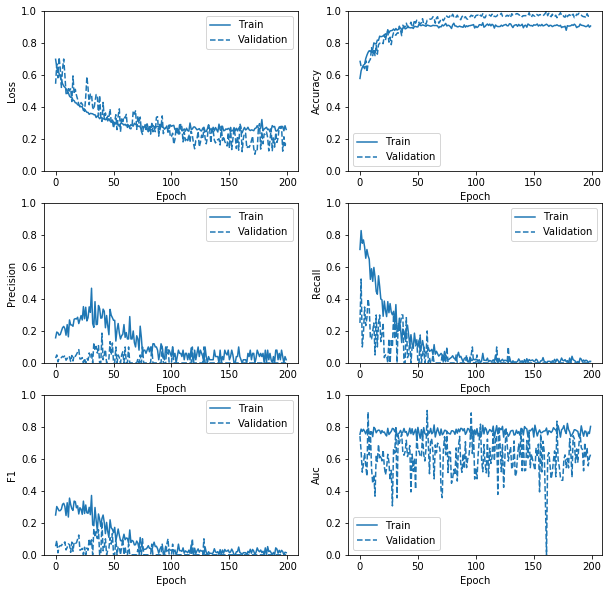

In [24]:
plt.figure(figsize=(10,10))
plot_metrics(up2_history)

### Train with UP3 (1:20)

In [25]:
# start = time.time()
# up3_history = model.fit_generator(up3_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps,
#                               class_weight = [0.5, 1],
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [26]:
# print("Time taken:",end-start)

In [27]:
# plt.figure(figsize=(10,10))
# plot_metrics(up3_history)

### Train with Imbalanced original train data (1:40)

In [28]:
# start = time.time()
# imb_history = model.fit_generator(imb_train_generator,
#                                   epochs=n_epochs,
#                                   steps_per_epoch=n_steps_per_epoch,
#                                   validation_data=validation_generator,
#                                   validation_steps=n_validation_steps,
#                                   class_weight = [0.5, 2],
#                                   callbacks=[reduce_lr]
#                                  )
# end = time.time()

In [29]:
# print("Time taken:",end-start)

In [30]:
# plt.figure(figsize=(10,10))
# plot_metrics(imb_history)

## Evaluation

In [31]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 20s 198ms/step


In [32]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.218 :   0.221
Accuracy : 0.965 :   0.977
Precision : 0.000 :   0.000
Recall : 0.000 :   0.000
F1 : 0.000 :   0.000
AUC : 0.563 :   0.626


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [33]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(1207.3781394958496, 195.189768075943)

In [34]:
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [35]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [36]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

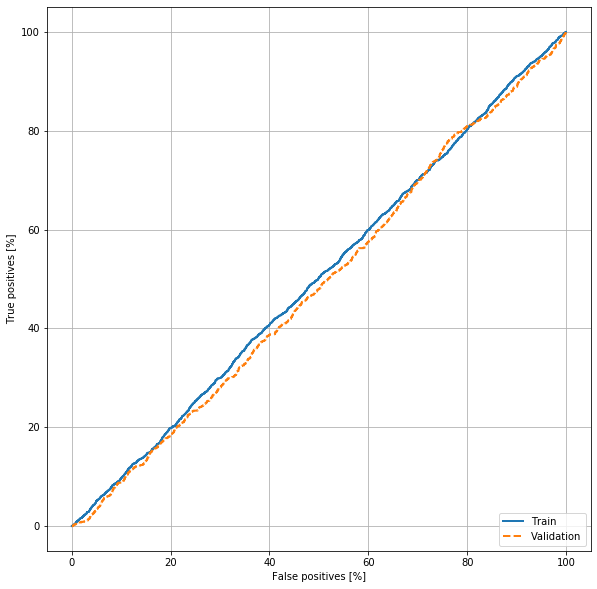

In [37]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 98789 
FP: 666 
FN: 2369 
TP: 10
Healthy Patients - correctly identified (True Negatives):  98789 0.9933035040973305
Healthy Patients - predicted to have glaucoma (False Positives):  666 0.006696495902669549
Glaucoma Patients - predicted healthy (False Negatives):  2369 0.9957965531736024
Glaucoma Patients - correctly identified (True Positives):  10 0.004203446826397646

Total Glaucoma patients:  2379 1.0
Total Healthy patients:  99455 1.0


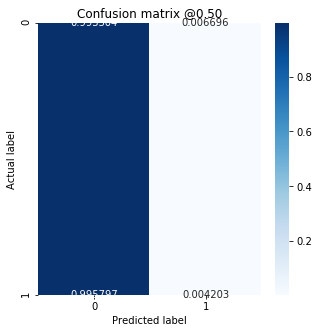

In [38]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 33096 
FP: 38 
FN: 809 
TP: 0
Healthy Patients - correctly identified (True Negatives):  33096 0.9988531417878916
Healthy Patients - predicted to have glaucoma (False Positives):  38 0.0011468582121084083
Glaucoma Patients - predicted healthy (False Negatives):  809 1.0
Glaucoma Patients - correctly identified (True Positives):  0 0.0

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


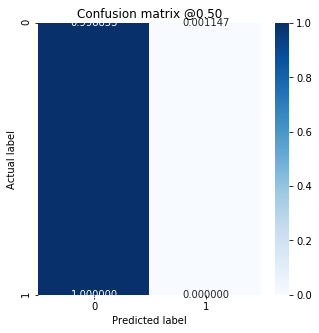

In [39]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [46]:
# history = up2_history
# tag_value = "trained twice bal and 1:10 with 84 tr layers"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

<IPython.core.display.Javascript object>

In [47]:
# client = MlflowClient()
# run = client.create_run('17')
# client.set_tag(run.info.run_id, "tag_key", tag_value)